In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from research_utils.database.database import Database
from research_utils.analytics.beta_regression import Beta
from research_utils.analytics.lda import TopicModel

In [2]:
database = Database()

In [3]:
sql = """
SELECT a.package_id, a.package, a.organization,
	   a.duration_median, a.duration_mean, a.duration_variance, a.project_age,
	   b.crowd_pct, b.crowd, b.total as total_issues,
	   c.gini_coefficient, c.avg_clustering, c.avg_min_path,
	   d.total_contributors, e.diversity_10, e.diversity_25, e.diversity_50, e.diversity_100,
       e.distributed, e.one_center, e.two_centers, e.multiple_centers, e.other,
       f.avg_comments
FROM(
	SELECT package_id, package, organization,
		   PERCENTILE_DISC(0.5) WITHIN GROUP (ORDER BY duration) AS duration_median,
		   AVG(duration) AS duration_mean,
		   VARIANCE(duration) AS duration_variance,
		   EXTRACT(DAY FROM NOW() - MIN(created_at)) AS project_age
	FROM(
		SELECT package_id, organization, package, created_at,
			   EXTRACT(DAY FROM closed_at - created_at) as duration
               FROM open_source.issues
               WHERE closed_at IS NOT NULL AND pull_request IS FALSE
               AND created_at < '2019-01-01'
                AND ('bug' = ANY(lower(labels::text)::text[])
                OR 'feature' = ANY(lower(labels::text)::text[])
            OR 'feature request' = ANY(lower(labels::text)::text[])
            OR 'change' = ANY(lower(labels::text)::text[])
            OR 'suggestion' = ANY(lower(labels::text)::text[])
            OR 'enhancement' = ANY(lower(labels::text)::text[]))
		
	) z
	GROUP BY package_id, organization, package
) a
INNER JOIN open_source.crowd_percentage b
ON a.package_id = b.package_id
INNER JOIN (
	SELECT organization, package, gini_coefficient, avg_clustering, avg_min_path, crowd_pct
	FROM open_source.stakeholder_networks
) c
ON (a.package = c.package AND a.organization = c.organization)
INNER JOIN (
	SELECT COUNT(DISTINCT user_id) as total_contributors, package_id
	FROM open_source.issue_contributors
    WHERE commit_pct > 0
	GROUP BY package_id
) d
ON a.package_id = d.package_id
INNER JOIN open_source.packages e
ON a.package_id = e.id
INNER JOIN (
    SELECT AVG(num_comments) as avg_comments, package, organization
    FROM (
        SELECT COUNT(DISTINCT comment_id) as num_comments, issue_id, package, organization
        FROM open_source.issue_comments
        GROUP BY issue_id, package, organization
    ) x
    GROUP BY package, organization
) f
ON (a.package = f.package AND a.organization = f.organization)
"""
data = pd.read_sql(sql, database.connection)

In [4]:
tm = TopicModel(25, load=True)

In [5]:
df = tm.load_topic_model_results()

In [6]:
df.head()

,issue_time,issue_id,title,body,organization,package,issue_number,all_content,topics
0,2018-05-03 11:33:46,319883485,"Help command line arguments (-h, --help) are i...",The help arguments implicitly defined by the a...,actor-framework,actor-framework,688,"Help command line arguments (-h, --help) are i...","[0.009083141572773457, 0.009083141572773457, 0..."
1,2015-02-24 20:11:09,58796753,Remove match expr,The main objective of this change is to make C...,actor-framework,actor-framework,242,Remove match expr The main objective of this c...,"[0.006975634954869747, 0.006975634954869747, 0..."
2,2014-12-18 16:09:28,52381894,Enable actor publishing at random high-level port,"With this patch, using 0 as port parameter to ...",actor-framework,actor-framework,218,Enable actor publishing at random high-level p...,"[0.008186651393771172, 0.008186651393771172, 0..."
3,2018-01-08 17:03:43,286813990,The udp basp autoconnection test has a leak,"According to asan, there is a leak in the unit...",actor-framework,actor-framework,647,The udp basp autoconnection test has a leak Ac...,"[0.010533114895224571, 0.3219645917415619, 0.0..."
4,2014-12-17 11:32:12,52229707,Topic/pullrequest,More tests for the jenkins PR builder.\n,actor-framework,actor-framework,216,Topic/pullrequest More tests for the jenkins P...,"[0.013114626519382, 0.013114626519382, 0.01311..."


In [7]:
for i in range(tm.num_topics):
    df['topic_{}'.format(i)] = [x[i] if x else np.nan for x in df['topics']]
    df['topic_{}_2'.format(i)] = df['topic_{}'.format(i)]**2

In [8]:
all_topics = []
reg_topics = []
for i in range(tm.num_topics-1):    
    all_topics.append('topic_{}'.format(i))
    all_topics.append('topic_{}_2'.format(i))
    for j in range(tm.num_topics-1):
        reg_topics.append("topic_{}*topic_{}".format(i, j))
        reg_topics.append("topic_{}_2".format(i, j))

In [9]:
mean_topics = df.groupby(['organization', 'package']).mean()[all_topics]

In [10]:
all_data = mean_topics.merge(data, on=['package', 'organization'])

In [11]:
all_data['crowd_pct_sq'] = np.sqrt(all_data['crowd_pct'])
all_data['crowd_pct_2'] = all_data['crowd_pct']**2
all_data['issues_over_time'] = (all_data['total_issues'] / all_data['project_age'])*7
all_data['avg_clusteringXcrowd_pct'] = all_data['avg_clustering'] * all_data['crowd_pct']
all_data['avg_min_pathXcrowd_pct'] = all_data['avg_min_path'] * all_data['crowd_pct']
all_data['gini_coefficientXcrowd_pct'] = all_data['gini_coefficient'] * all_data['crowd_pct']

In [12]:
base_columns = ['crowd_pct', 'crowd_pct_2',
                'avg_clustering', 'avg_min_path', 'gini_coefficient',
                'avg_clusteringXcrowd_pct', 'avg_min_pathXcrowd_pct', 'gini_coefficientXcrowd_pct',
                'total_contributors', 'project_age']
base_features = ' + '.join(base_columns)

In [13]:
def select_features(X, y, threshold, model_type='ols'):
    cols = list(X.columns)
    pmax = 1
    while (len(cols)>0):
        p= []
        X_1 = X[cols]
        if model_type == 'ols':
            model = sm.OLS(y,X_1).fit()
        elif model_type == 'poisson':
            model = sm.GLM(y, X_1, family=sm.families.Poisson()).fit()
        elif model_type == 'negative_binomial':
            model = sm.GLM(y, X_1, family=sm.families.NegativeBinomial()).fit()
        elif model_type == 'gamma':
            model = sm.GLM(y, X_1, family=sm.families.Gamma(link=sm.families.links.log)).fit()
        p = pd.Series(model.pvalues.values,index = cols)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>threshold):
            cols.remove(feature_with_p_max)
        else:
            break
    features = ' + '.join(cols[1:])
    return features

### Regression on Average Comments

In [14]:
y, X = dmatrices('avg_comments ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_comments   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     21.78
Date:                Sat, 23 Nov 2019   Prob (F-statistic):           2.32e-34
Time:                        15:15:16   Log-Likelihood:                -746.16
No. Observations:                 562   AIC:                             1514.
Df Residuals:                     551   BIC:                             1562.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [15]:
y, X = dmatrices('avg_comments ~ ' + base_features + ' + ' + ' + '.join(reg_topics),
                 data=all_data, return_type='dataframe')
features = select_features(X, y, .05)
y, X = dmatrices('avg_comments ~ ' + features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_comments   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     9.776
Date:                Sat, 23 Nov 2019   Prob (F-statistic):           3.30e-41
Time:                        15:15:34   Log-Likelihood:                -685.68
No. Observations:                 562   AIC:                             1451.
Df Residuals:                     522   BIC:                             1625.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

(-2.0, 2.0)

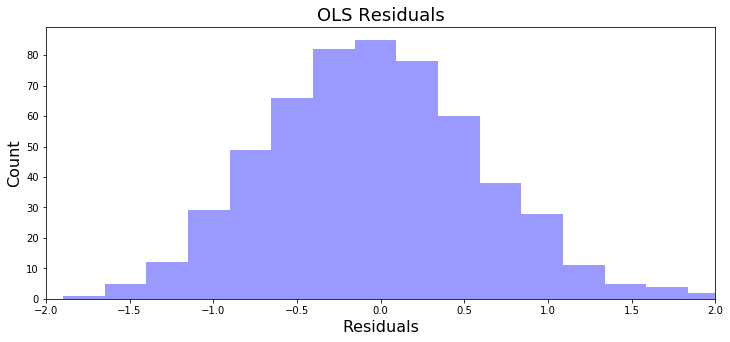

In [16]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-2.0, 2.0])

(-2.0, 2.0)

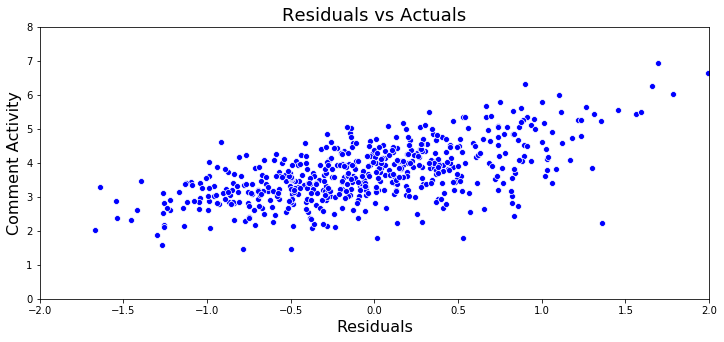

In [17]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['avg_comments'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Comment Activity', fontsize=16)
plt.ylim([0, 8])
plt.xlim([-2.0, 2.0])

In [18]:
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(res.summary())

2019-11-23 15:15:35,306 [8467] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.



0.5024091203156327
                 Generalized Linear Model Regression Results                  
Dep. Variable:           avg_comments   No. Observations:                  562
Model:                            GLM   Df Residuals:                      522
Model Family:                   Gamma   Df Model:                           39
Link Function:                    log   Scale:                        0.039572
Method:                          IRLS   Log-Likelihood:                -575.73
Date:                Sat, 23 Nov 2019   Deviance:                       18.892
Time:                        15:15:35   Pearson chi2:                     20.7
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Inter

(0, 1.5)

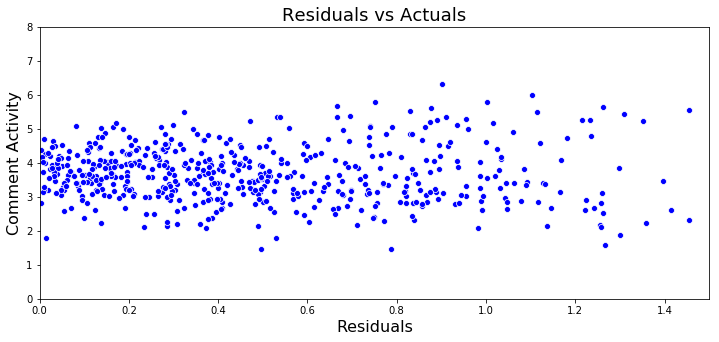

In [19]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=abs(yhat - all_data['avg_comments']), y=all_data['avg_comments'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Comment Activity', fontsize=16)
plt.ylim([0, 8])
plt.xlim([0, 1.5])

### Regression on Mean Requirement Duration

In [20]:
y, X = dmatrices('duration_mean ~ ' + base_features + ' + total_issues ',
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          duration_mean   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     22.62
Date:                Sat, 23 Nov 2019   Prob (F-statistic):           2.75e-38
Time:                        15:15:36   Log-Likelihood:                -3524.3
No. Observations:                 562   AIC:                             7073.
Df Residuals:                     550   BIC:                             7125.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [21]:
y, X = dmatrices('duration_mean ~ ' + base_features + ' + total_issues + ' + ' + '.join(reg_topics),
                 data=all_data, return_type='dataframe')
features = select_features(X, y, .10)
y, X = dmatrices('duration_mean ~ crowd_pct + avg_clusteringXcrowd_pct - avg_clustering ' + features ,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          duration_mean   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     7.796
Date:                Sat, 23 Nov 2019   Prob (F-statistic):           2.27e-48
Time:                        15:16:03   Log-Likelihood:                -3402.6
No. Observations:                 562   AIC:                             6961.
Df Residuals:                     484   BIC:                             7299.
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

(-250, 250)

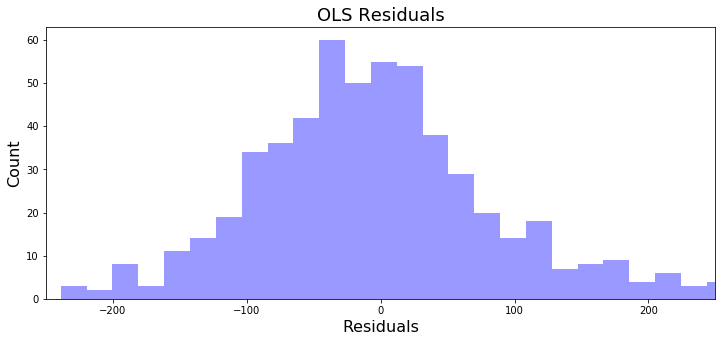

In [22]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-250, 250])

(-200, 200)

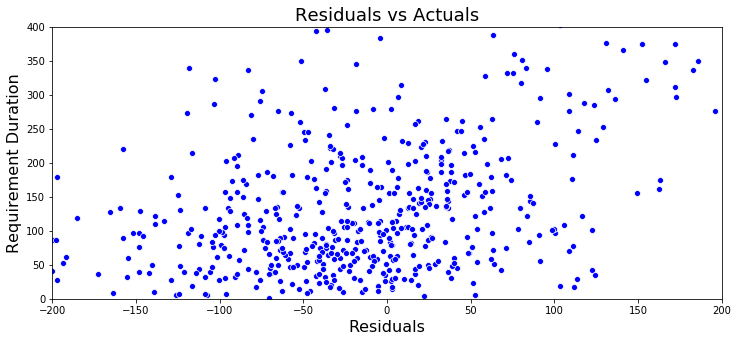

In [23]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['duration_mean'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Requirement Duration', fontsize=16)
plt.ylim([0, 400])
plt.xlim([-200, 200])

In [24]:
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(res.summary())
yhat = res.predict(X)

2019-11-23 15:16:04,237 [8467] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.



0.509924230048675
                 Generalized Linear Model Regression Results                  
Dep. Variable:          duration_mean   No. Observations:                  562
Model:                            GLM   Df Residuals:                      484
Model Family:                   Gamma   Df Model:                           77
Link Function:                    log   Scale:                         0.39643
Method:                          IRLS   Log-Likelihood:                -3194.3
Date:                Sat, 23 Nov 2019   Deviance:                       219.90
Time:                        15:16:04   Pearson chi2:                     192.
No. Iterations:                    33                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Interc

(0, 200)

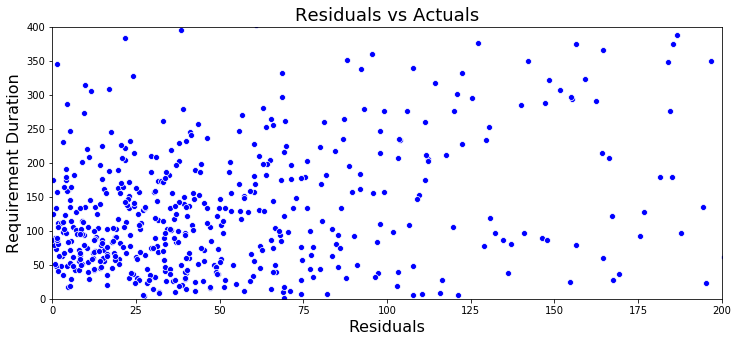

In [25]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=abs(yhat - all_data['duration_mean']), y=all_data['duration_mean'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Requirement Duration', fontsize=16)
plt.ylim([0, 400])
plt.xlim([0, 200])

### Regression on Issues Submitted Over Time

In [26]:
y, X = dmatrices('issues_over_time ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       issues_over_time   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     45.75
Date:                Sat, 23 Nov 2019   Prob (F-statistic):           5.09e-66
Time:                        15:16:05   Log-Likelihood:                -433.09
No. Observations:                 562   AIC:                             888.2
Df Residuals:                     551   BIC:                             935.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [27]:
y, X = dmatrices('issues_over_time ~ ' + base_features + ' + ' + ' + '.join(reg_topics),
                 data=all_data, return_type='dataframe')
features = select_features(X, y, .05)
y, X = dmatrices('issues_over_time ~ ' + features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       issues_over_time   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     23.83
Date:                Sat, 23 Nov 2019   Prob (F-statistic):          3.31e-119
Time:                        15:16:22   Log-Likelihood:                -183.28
No. Observations:                 562   AIC:                             510.6
Df Residuals:                     490   BIC:                             822.4
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

(-1.0, 1.0)

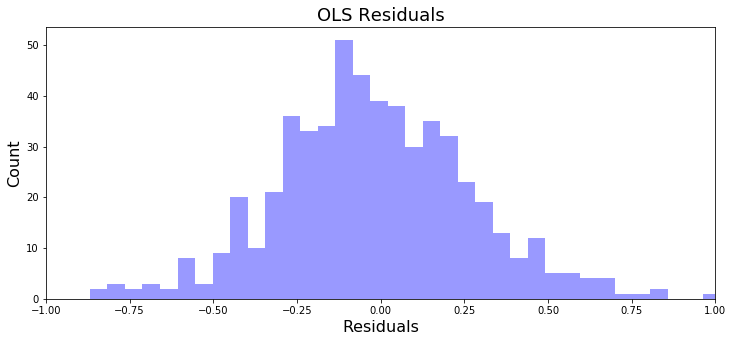

In [28]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-1.0, 1.0])

(-0.75, 0.75)

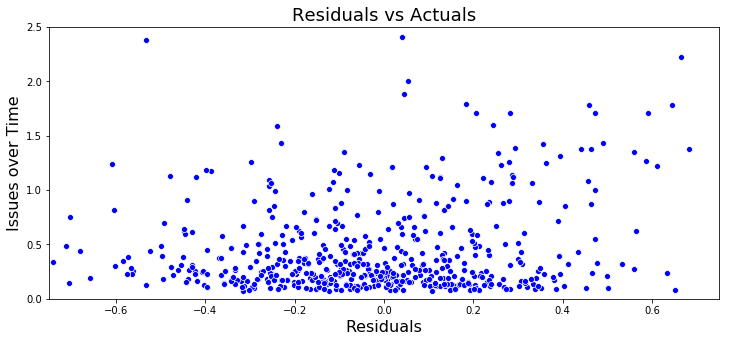

In [29]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['issues_over_time'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Issues over Time', fontsize=16)
plt.ylim([0, 2.5])
plt.xlim([-0.75, .75])